# Full Example
THe idea with this NB is to do the same as the pymc_prophet_example NB but do everything (holidays, regressors etc...) in a single example and compare pymc_prohet with prophet. Then we will use this to build the Bayesian PyMC component.

In [1]:
from pymcprophet.model import BayesTS, BayesTSConfig
from prophet import Prophet

import datetime as dt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")


Running on PyMC v5.20.1


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df['ds'] = pd.to_datetime(df['ds'])

## Holidays
These are user defined. We will also add auto US ones.

In [3]:
np.random.default_rng(RANDOM_SEED)

Generator(PCG64) at 0x782055B7E500

In [4]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

## Regressor
Custom dataset for Sundays during the NFL Season.

In [5]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

## Modelling

In [6]:
train_df = df.query("ds.dt.year <= 2014")
test_df = df.query("ds.dt.year > 2014")

### PyMC

In [11]:
ts_config = BayesTSConfig()
ts_model = BayesTS(ts_config)
ts_model.add_holiday_country("US")
ts_model.add_holiday(holidays)
ts_model.add_regressor("nfl_sunday", mode="additive")

# ts_model.assign_model_matrix(train_df)

In [12]:
ts_model.fit(train_df)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, m, beta_additive, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y_obs]


Output()

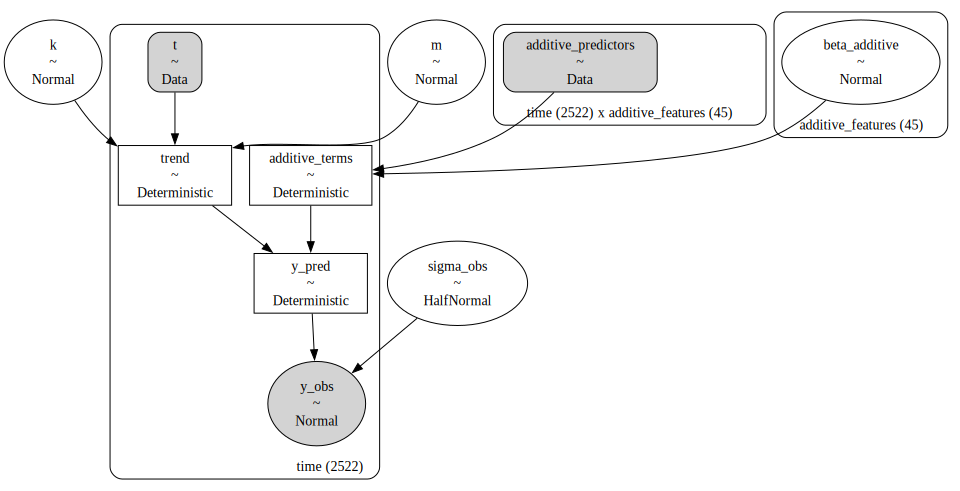

In [9]:
pm.model_to_graphviz(ts_model.forecast_model)

In [ ]:
additive_present = bool(ts_model.model_spec.get_bayes_feature_dict(mode="additive"))
multiplicative_present = bool(ts_model.model_spec.get_bayes_feature_dict(mode="multiplicative"))

y = ts_model.model_df["y_trans"].to_numpy()
t_np = ts_model.model_df["t"].to_numpy()
coords = {
    "time": ts_model.model_df["ds"],
}

if additive_present:
    additive_feature_dict = ts_model.model_spec.get_bayes_feature_dict(mode="additive")
    additive_feature_names = list(additive_feature_dict.keys())
    additive_prior_mus = np.array([feature.prior_params["mu"] for feature in additive_feature_dict.values()])
    additive_prior_sigmas = np.array([feature.prior_params["sigma"] for feature in additive_feature_dict.values()])
    X_additive = ts_model.model_df[additive_feature_names].to_numpy()
    coords["additive_features"] = additive_feature_names

if multiplicative_present:
    multiplicative_feature_dict = ts_model.model_spec.get_bayes_feature_dict(mode="multiplicative")
    multiplicative_feature_names = list(multiplicative_feature_dict.keys())
    multiplicative_prior_mus = np.array([feature.prior_params["mu"] for feature in multiplicative_feature_dict.values()])
    multiplicative_prior_sigmas = np.array([feature.prior_params["sigma"] for feature in multiplicative_feature_dict.values()])
    X_multiplicative = ts_model.model_df[multiplicative_feature_names].to_numpy()
    coords["multiplicative_features"] = multiplicative_feature_names

forecast_model = pm.Model(coords=coords)

with forecast_model:
    # trend(t) applies to k(t-m),
    k = pm.Normal("k", mu=0, sigma=5)
    m = pm.Normal("m", mu=0, sigma=5)
    t = pm.Data("t", t_np, dims="time")
    trend = pm.Deterministic("trend", k * t + m, dims="time")

    # defaults get overwritten by additive or multiplicative terms if present
    additive_terms = 0
    multiplicative_terms = 0

    if additive_present:
        additive_predictors = pm.Data("additive_predictors", X_additive, dims=["time", "additive_features"])
        beta_additive = pm.Normal(
            "beta_additive",
            mu=additive_prior_mus,
            sigma=additive_prior_sigmas,
            dims="additive_features",
        )
        additive_terms = pm.Deterministic(
            "additive_terms",
            additive_predictors @ beta_additive,
            dims="time",
        )

    if multiplicative_present:
        multiplicative_predictors = pm.Data("multiplicative_predictors", X_multiplicative, dims=["time", "multiplicative_features"])
        beta_multiplicative = pm.Normal(
            "beta_multiplicative",
            mu=multiplicative_prior_mus,
            sigma=multiplicative_prior_sigmas,
            dims="multiplicative_features",
        )
        multiplicative_terms = pm.Deterministic(
            "multiplicative_terms",
            multiplicative_predictors @ beta_multiplicative,
            dims="time",
        )

    # predictions
    y_pred = pm.Deterministic("y_pred", trend * (1 + multiplicative_terms) + additive_terms, dims="time")

    # observation
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=0.5)
    y_obs = pm.Normal("y_obs", mu=y_pred, sigma=sigma_obs, observed=y, dims="time")

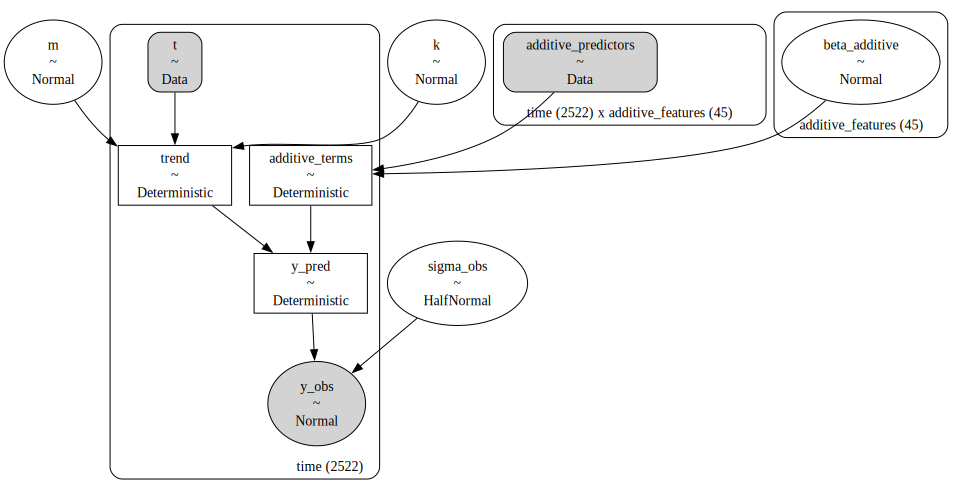

In [ ]:
pm.model_to_graphviz(forecast_model)

#### Prior Predictive

In [ ]:
with forecast_model:
    # prior predictive sample
    prior_idata = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [beta_additive, k, m, sigma_obs, y_obs]


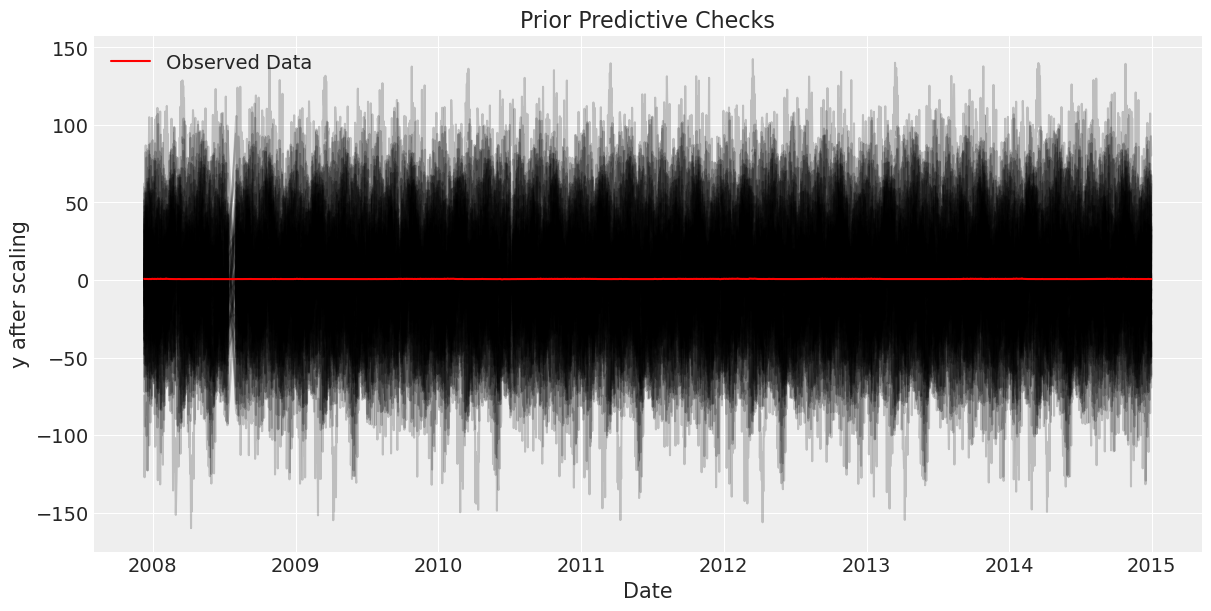

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted size

# Plot prior predictive samples
# ax.plot(prior_idata.constant_data["time"], prior_idata.prior["y_pred"].stack(sample=("chain", "draw")), c="k", alpha=0.2)
ax.plot(prior_idata.constant_data["time"], prior_idata.prior_predictive["y_obs"].stack(sample=("chain", "draw")), c="k", alpha=0.2)

# Plot actual observed data
ax.plot(prior_idata.constant_data["time"], y, c="r", label="Observed Data")

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("y after scaling")
ax.set_title("Prior Predictive Checks")
ax.legend()
ax.grid(True)

plt.show()

#### In Sample Posterior

In [ ]:
with forecast_model:
    posterior_idata = pm.sample(chains=4, draws=2000, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, m, beta_additive, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [ ]:
with forecast_model:
    posterior_predictive_idata = pm.sample_posterior_predictive(posterior_idata, random_seed=rng)

NameError: name 'forecast_model' is not defined

In [ ]:
import plotly.graph_objects as go

In [ ]:
alpha = 0.05

# posterior_idata.posterior["y_pred"]
posterior_array = posterior_predictive_idata.posterior_predictive["y_obs"]
region_color = "mediumblue"


fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=posterior_idata.constant_data["time"],
        y=posterior_array.quantile(q=1 - alpha / 2, dim=("chain", "draw")),
        fill=None,
        mode="lines",
        line=dict(width=0, color=region_color),
        name=f"{100 - 50 * alpha} percent",
    )
)

fig.add_trace(
    go.Scatter(
        x=posterior_idata.constant_data["time"],
        y=posterior_array.quantile(q=alpha / 2, dim=("chain", "draw")),
        fill="tonexty",  # fill area between trace0 and trace1
        mode="lines",
        line=dict(width=0, color=region_color),
        name=f"{50 * alpha} percent",
    )
)

fig.add_trace(
    go.Scatter(
        x=posterior_idata.constant_data["time"],
        y=posterior_array.mean(("chain", "draw")),
        name="y_pred_mean",
        mode="lines",
        line=dict(width=1, color=region_color),
    )
)

fig.add_trace(
    go.Scatter(
        x=posterior_idata.constant_data["time"],
        y=posterior_idata.observed_data["y_obs"],
        mode="markers",
        marker=dict(color="red", size=4, opacity=0.6),
        name="y actual",
    )
)


fig.show()

### Prophet

In [ ]:
prophet_model = Prophet(holidays=holidays)
prophet_model.add_country_holidays(country_name='US')
prophet_model.add_regressor('nfl_sunday')

In [ ]:
transformed = prophet_model.preprocess(train_df)

In [ ]:
prophet_model = Prophet(holidays=holidays)
prophet_model.add_country_holidays(country_name='US')
prophet_model.add_regressor('nfl_sunday')
prophet_model.fit(train_df)

12:43:43 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
test_df['y']

2522     7.846590
2523     8.302018
2524     8.436200
2525     8.934587
2526     8.888619
          ...    
2900     7.817223
2901     9.273878
2902    10.333775
2903     9.125871
2904     8.891374
Name: y, Length: 383, dtype: float64

/home/jake/miniforge3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:196: UserWarning:

The figure layout has changed to tight



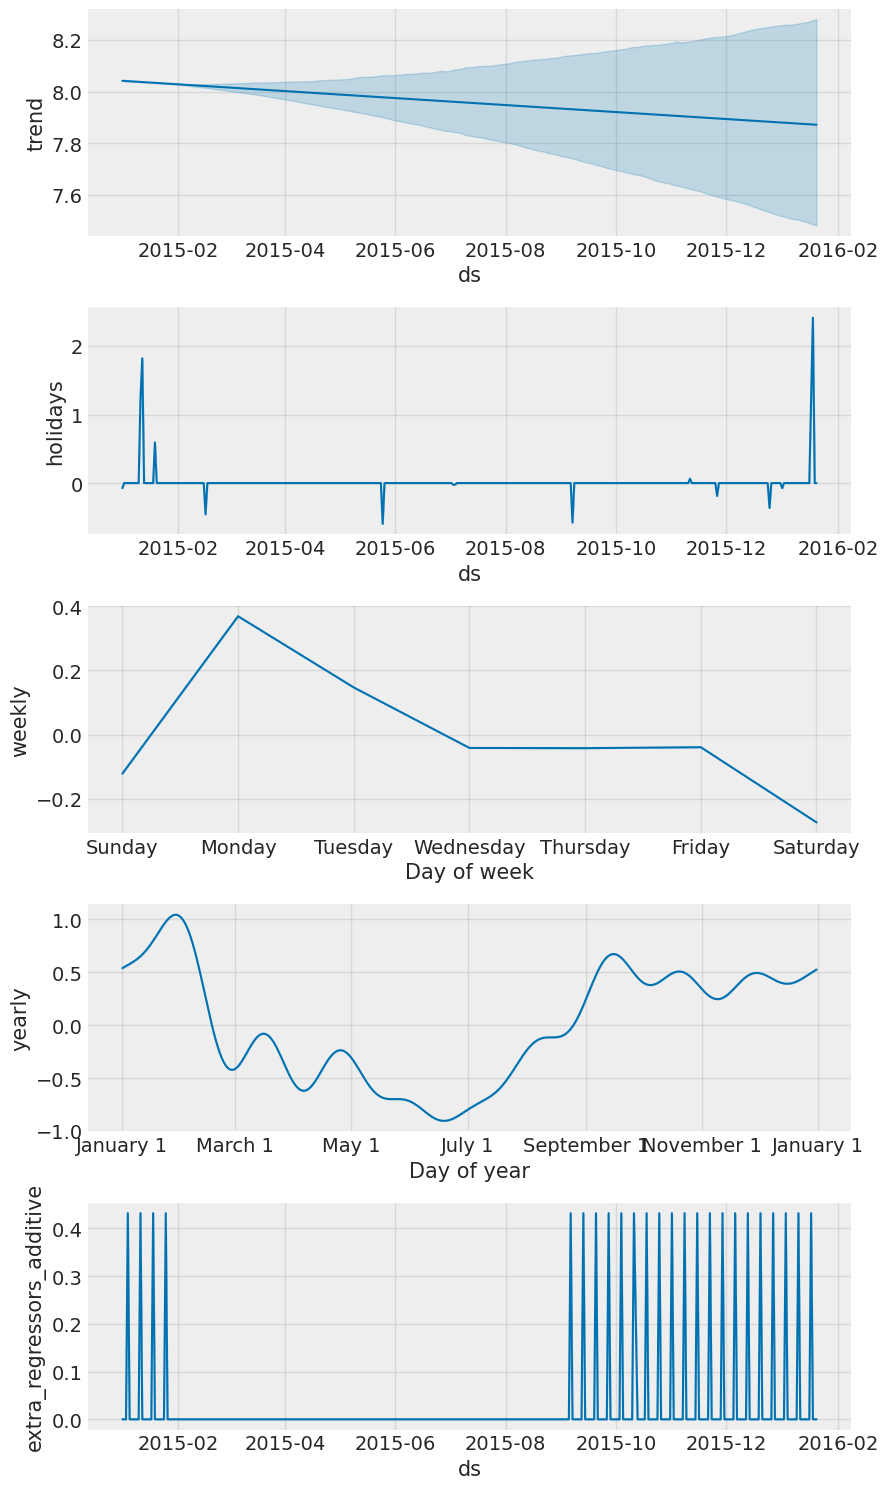

In [ ]:
forecast = prophet_model.predict(test_df)
fig = prophet_model.plot_components(forecast)